# Data Science with Hadoop - Predicting airline delays with Apache HIVE and R

# Introduction

With the rapid adoption of Apache Hadoop in the enterprise, machine learning is becoming a key technology used by enterprises to extract tangible business value from their massive data assets. This derivation of business value is possible because Apache Hadoop YARN as the architectural center of Modern Data Architecture (MDA) allows purpose-built data engines such as Apache Tez and Apache Spark to process and iterate over multiple datasets for data science techniques within the same cluster.

It is a common misconception that the way we apply predictive learning algorithms like Linear Regression, Random Forest or Neural Networks to large datasets requires a dramatic change in approach, in tooling, or dedicated, siloed clusters. In fact, the big change is in what is known as “feature engineering” – the process by which very big raw data is transformed into a “feature matrix”. Enabled by Hadoop with YARN as an ideal platform, this transformation of large raw datasets (terabytes or petabytes) into a feature matrix is now scalable and not limited by RAM or compute power of a single node.

Since the output of the feature engineering step (the "feature matrix") tends to be relatively small in size (typically in the 2-20GB range), a common choice is to run the learning algorithm on a single machine (often with multiple cores and high amount of RAM), allowing us to utilize a plethora of existing robust tools and algorithms from R packages, Python's Scikit-learn, SAS or others.

In this interactive IPython notebook we will demonstrate, via an example, a step by step solution to a supervised learning problem using HIVE (with R UDFs) for pre-processing and R for modeling. 

[R](http://www.r-project.org/) is a language and environment for statistical computing and graphics. It is a GNU project which was developed at Bell Laboratories by John Chambers and his colleagues. R is an open source project with more than 6000 packages available covering various topics in data science including classification, regression, clustering, anomaly detection, market basket analysis, text processing and many others. R is an extremely powerful and mature environment for statistical analysis and data science.

[Apache HIVE](https://hive.apache.org/) is the de-facto SQL-on-Hadoop tool, originally developed at Facebook and now a fast, mature and effective tool for data analytics. HIVE provides a rich set of built-in funtionality, and is extensible via user-defined functions (e.g. in Java or Python) enabling custom business logic. 

# Predicting flight delays with HIVE and R

Every year approximately 20% of airline flights are delayed or cancelled, resulting in significant costs to both travellers and airlines. As our example use-case, we will build a supervised learning model that predicts airline delay from historial flight data and weather information. 

<img src=http://venturevillage.eu/wp-content/uploads/2013/02/Flight-delays.jpeg>

Let's begin by exploring the airline delay dataset available here:  http://stat-computing.org/dataexpo/2009/the-data.html
This dataset includes details about flights in the US from the years 1987-2008. Every row in the dataset includes 29 variables:
<table width="100%">
<tr>
  <th></th>
  <th>Name</th>
  <th>Description</th>
</tr>
<tr>
 <td>1  </td><td> Year              </td><td>1987-2008</td>
</tr><tr>
 <td>2  </td><td> Month             </td><td>1-12</td>
</tr><tr>
 <td>3  </td><td> DayofMonth        </td><td>1-31</td>
</tr><tr>
 <td>4  </td><td> DayOfWeek         </td><td>1 (Monday) - 7 (Sunday)</td>
</tr><tr>
 <td>5  </td><td> DepTime           </td><td>actual departure time (local, hhmm)</td>
</tr><tr>
 <td>6  </td><td> CRSDepTime        </td><td>scheduled departure time (local, hhmm)</td>
</tr><tr>
 <td>7  </td><td> ArrTime           </td><td>actual arrival time (local, hhmm)</td>
</tr><tr>
 <td>8  </td><td> CRSArrTime        </td><td>scheduled arrival time (local, hhmm)</td>
</tr><tr>
 <td>9  </td><td> UniqueCarrier     </td><td>unique carrier code</td>
</tr><tr>
 <td>10 </td><td> FlightNum         </td><td>flight number</td>
</tr><tr>
 <td>11 </td><td> TailNum           </td><td>plane tail number</td>
</tr><tr>
 <td>12 </td><td> ActualElapsedTime </td><td>in minutes</td>
</tr><tr>
 <td>13 </td><td> CRSElapsedTime    </td><td>in minutes</td>
</tr><tr>
 <td>14 </td><td> AirTime           </td><td>in minutes</td>
</tr><tr>
 <td>15 </td><td> ArrDelay          </td><td>arrival delay, in minutes</td>
</tr><tr>
 <td>16 </td><td> DepDelay          </td><td>departure delay, in minutes</td>
</tr><tr>
 <td>17 </td><td> Origin            </td><td>origin - IATA airport code</td>
</tr><tr>
 <td>18 </td><td> Dest              </td><td>destination - IATA airport code</td>
</tr><tr>
 <td>19 </td><td> Distance          </td><td>in miles</td>
</tr><tr>
 <td>20 </td><td> TaxiIn            </td><td>taxi in time, in minutes</td>
</tr><tr>
 <td>21 </td><td> TaxiOut           </td><td>taxi out time in minutes</td>
</tr><tr>
 <td>22 </td><td> Cancelled           </td><td>was the flight cancelled?</td>
</tr><tr>
 <td>23 </td><td> CancellationCode  </td><td>reason for cancellation (A = carrier, B = weather, C = NAS, D = security)</td>
</tr><tr>
 <td>24 </td><td> Diverted          </td><td>1 = yes, 0 = no</td>
</tr><tr>
 <td>25 </td><td> CarrierDelay      </td><td>in minutes</td>
</tr><tr>
 <td>26 </td><td> WeatherDelay      </td><td>in minutes</td>
</tr><tr>
 <td>27 </td><td> NASDelay          </td><td>in minutes</td>
</tr><tr>
 <td>28 </td><td> SecurityDelay     </td><td>in minutes</td>
</tr><tr>
 <td>29 </td><td> LateAircraftDelay </td><td>in minutes</td>
</tr>
</table>

Before we start modeling, let's do some exploration of this dataset.

# Data Exploration

R is a fantastic environment for data exploration and is often used for this purpose. With a ton of statistical and data manipulation functionality being part of core R, as well as powerful graphics packages such as ggplot2, performing data exploration in R is easy and fun.

Then we load RJDBC and setup the connection to HIVE. We also define the exec.query() function to remove the table name from column names in the result set, for convenience:

In [1]:
require(rJava)
require(RJDBC)

drv <- JDBC("org.apache.hive.jdbc.HiveDriver", 
            classPath = c("/usr/hdp/current/hive-client/lib/hive-jdbc.jar", 
                          "/usr/hdp/current/hadoop-client/hadoop-common.jar"))
conn <- dbConnect(drv, "jdbc:hive2://ml-master.cloud.hortonworks.com:10000/demo", "jupyter", "hadoop")

exec.query <- function(query) {
    df = dbGetQuery(conn, query)
    names(df) = sapply(names(df), function(x) {
        x = unlist(strsplit(x, split='.', fixed=T))
        if (length(x)>1) x[2] else x[1]
    }) 
    df
}

Loading required package: rJava
Loading required package: RJDBC
Loading required package: DBI


Let's take a quick look at the data:

In [2]:
df_samp = exec.query("SELECT * FROM flights WHERE year=2007 LIMIT 5")
print(df_samp)

  year month day dayofweek deptime crsdeptime arrtime crsarrtime carrier
1 2007     1   1         1    1232       1225    1341       1340      WN
2 2007     1   1         1    1918       1905    2043       2035      WN
3 2007     1   1         1    2206       2130    2334       2300      WN
4 2007     1   1         1    1230       1200    1356       1330      WN
5 2007     1   1         1     831        830     957       1000      WN
  flightnum tailnum actualelapsedtime crselapsedtime airtime arrdelay depdelay
1      2891    N351                69             75      54        1        7
2       462    N370                85             90      74        8       13
3      1229    N685                88             90      73       34       36
4      1355    N364                86             90      75       26       30
5      2278    N480                86             90      74       -3        1
  origin dest distance taxiin taxiout cancelled cancellationcode diverted
1    SMF  ONT 

Our "target" variable will be *depdelay* (departure delay in minutes). To build a classifier, we define a derived target variable by defining a "delay" as having 15 mins or more of delay, and "non-delay" otherwise. We thus replace *depdelay* with a new binary variable of the same name.

Let's explore some basic statostocs about the dataset: number of flights and delays (per our new definition), after limiting ourselves to flights originating from ORD (Chicago O'Hare airport):

In [3]:
num_rows = exec.query("SELECT COUNT(*) FROM flights WHERE year=2007")
print(paste0("total flights in 2007: ", as.numeric(num_rows[1])))

df1 = exec.query("SELECT * FROM flights WHERE year=2007 and origin='ORD' and depdelay is not NULL")
df1$depdelay = sapply(df1$depdelay, function(x) (if (as.numeric(x)>=15) 1 else 0))

print(paste0("total flights originating from ORD: ", as.character(dim(df1)[1])))
print(paste0("total delayed flights originating from ORD: ", as.character(sum(df1$depdelay))))

[1] "total flights in 2007: 7453215"
[1] "total flights originating from ORD: 359169"
[1] "total delayed flights originating from ORD: 109346"


The "month" feature is likely a good feature for modeling -- let's look at the distribution of delays (as percentage of total flights) by month:

Loading required package: plyr


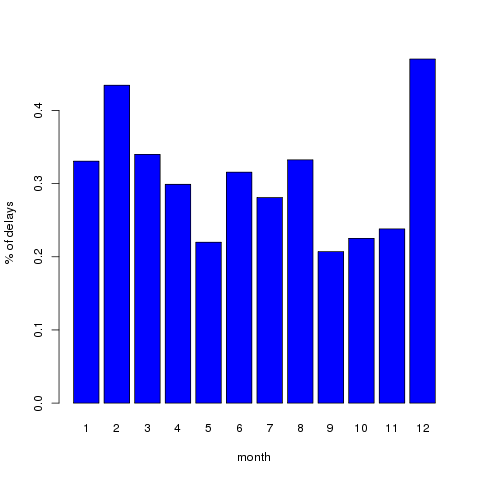

In [4]:
require(plyr)
df2 = df1[, c('depdelay', 'month')]
df2$month = as.numeric(df2$month)
df2 <- ddply(df2, .(month), summarise, mean_delay=mean(depdelay))
barplot(df2$mean_delay, names.arg=df2$month, xlab="month", ylab="% of delays", col="blue")

Similarly, one would expect that "hour of day" would be a good feature to predict flight delays, as later flights in the day may present more delays due to density effects. Let's look at that:

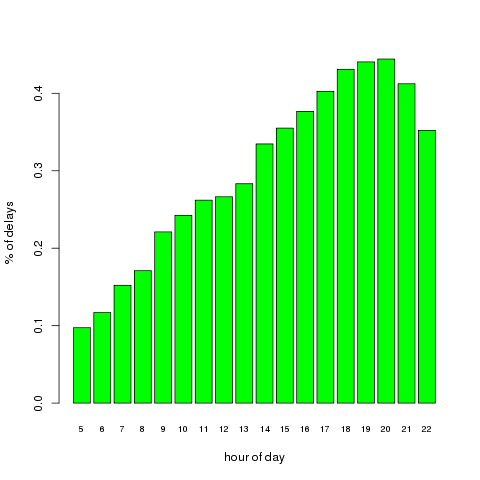

In [5]:
# Extract hour of day from 3 or 4 digit time-of-day string
get_hour <- function(x) { 
  s = sprintf("%04d", as.numeric(x))
  return(substr(s, 1, 2))
}

df2 = df1[, c('depdelay', 'crsdeptime')]
df2$hour = as.numeric(sapply(df2$crsdeptime, get_hour))
df2$crsdeptime <- NULL
df2 <- ddply(df2, .(hour), summarise, mean_delay=mean(depdelay))
barplot(df2$mean_delay, names.arg=df2$hour, xlab="hour of day", ylab="% of delays", col="green", cex.names=.7)

In this demo we have not explored all the variables of course, just a couple to demonstrate R's capabilities in this area. R has a wide variety of graphing tools suchas base, lattice and ggplot2.

## Pre-processing - iteration 1

After playing around with the data, and exploring some potential features -- we will now demonstrate how to use HIVE with a  UDF in R to preform some simple pre-processing on Hadoop, and create a feature matrix from the raw dataset. 

To simplify, we will build a supervised learning model to predict flight delays for flights leaving O'Hare International airport (ORD), where we "train" the model using data from 2007, and evaluate its performance using data from 2008.

In our first iteration, we create the following features:

* **month**: winter months should have more delays than summer months
* **day of month**: this is likely not a very predictive variable, but let's keep it in anyway
* **day of week**: weekend vs. weekday
* **Distance**: interesting to see if this variable is a good predictor of delay
* **hour of the day**: later hours tend to have more delays
* **days_from_closest_holiday**: number of days from date of flight to closest US holiday

We use HIVE with a UDF written in R, and create two "feature matrices", one for 2007 and another for 2008.
Let's look at the code. First we create our Hive UDF in R, and store it in the local folder:

In [6]:
hiveUdfStr = '
get_hour <- function(val) { return(substr(sprintf("%04d", val),1,2)) }

# get number of days from nearest holiday
holidays = sapply(c("2007-01-01", "2007-01-15", "2007-02-19", "2007-05-28", "2007-06-07", "2007-07-04",
                    "2007-09-03", "2007-10-08", "2007-11-11", "2007-11-22", "2007-12-25",
                    "2008-01-01", "2008-01-21", "2008-02-18", "2008-05-22", "2008-05-26", "2008-07-04",
                    "2008-09-01", "2008-10-13", "2008-11-11", "2008-11-27", "2008-12-25"),
                  function(x) { as.Date(x) })
days_from_nearest_holiday <- function(year, month, day) {
    d = as.Date(sprintf("%04d-%02d-%02d", year, month, day))
    v = sapply(holidays, function(h) { abs(as.integer(d-h)) })
    min(v)
}

input <- file("stdin", "r")
while(length(line <- readLines(input, n=1, warn=FALSE)) > 0) {
    if(nchar(line) == 0) break
    fields <- unlist(strsplit(line, "\t"))
    year = as.integer(fields[1]); month = as.integer(fields[2]); day = as.integer(fields[3]); 
    dayofweek = as.integer(fields[4]); depdelay = as.integer(fields[5]); 
    distance = as.integer(fields[6]); crsdeptime = as.integer(fields[7])
    delayed = if (!is.na(depdelay) && depdelay>15) 1 else 0
    out = paste(delayed, year, month, day, dayofweek, distance, 
                get_hour(crsdeptime), days_from_nearest_holiday(year, month, day), sep="\t")
    write(out, stdout())
}
'

fileConn<-file("/home/jupyter/notebooks/airline/hiveudf.R")
writeLines(hiveUdfStr, fileConn)
close(fileConn)

Next we crete a HIVE query, using this UDF, and execute it. This query extracts the basic features we are interested, such as month, day and distance, but also generates custom features such as hour, and day from nearest holiday via the HIVE UDF:

In [7]:
hiveScriptStr = "

USE demo;
ADD FILE /home/jupyter/notebooks/airline/hiveudf.R;

DROP TABLE fmat_2007;
CREATE TABLE fmat_2007 (delayed int, year int, month int, day int, dayofweek int, distance int, hour int, days_from_holiday int)
STORED AS ORC;

FROM (
    SELECT year, month, day, dayofweek, depdelay, distance, crsdeptime 
    FROM flights
    WHERE flights.year=2007 and flights.origin='ORD' and flights.cancelled=0 and flights.depdelay is not NULL
    DISTRIBUTE BY month
) t1
INSERT OVERWRITE TABLE fmat_2007
REDUCE year, month, day, dayofweek, depdelay, distance, crsdeptime
USING 'Rscript hiveudf.R' AS (delayed, year, month, day, dayofweek, distance, hour, days_from_holiday);

DROP TABLE fmat_2008;
CREATE TABLE fmat_2008 (delayed int, year int, month int, day int, dayofweek int, distance int, hour int, days_from_holiday int)
STORED AS ORC;

FROM (
    SELECT year, month, day, dayofweek, depdelay, distance, crsdeptime 
    FROM flights
    WHERE flights.year=2008 and flights.origin='ORD' and flights.cancelled=0 and flights.depdelay is not NULL
    DISTRIBUTE BY month
) t1
INSERT OVERWRITE TABLE fmat_2008
REDUCE year, month, day, dayofweek, depdelay, distance, crsdeptime
USING 'Rscript hiveudf.R' AS (delayed, year, month, day, dayofweek, distance, hour, days_from_holiday);

"

scriptFile = "/home/jupyter/notebooks/airline/iter1.hql"
fileConn<-file(scriptFile)
writeLines(hiveScriptStr, fileConn)
close(fileConn)

system2("hive", c("-f", scriptFile))


## Modeling - iteration 1

Now that we've generated our feature matrix using HIVE, let's turn back to using R to build a model for predicting airline delays. First we read the feature matrices, and define a helper function (get_metrics) in R to compute the classification metrics:

In [8]:
# Function to compute Precision, Recall and F1-Measure
get_metrics <- function(predicted, actual) {
  tp = length(which(predicted == TRUE & actual == TRUE))
  tn = length(which(predicted == FALSE & actual == FALSE))
  fp = length(which(predicted == TRUE & actual == FALSE))
  fn = length(which(predicted == FALSE & actual == TRUE))

  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  F1 = 2*precision*recall / (precision+recall)
  accuracy = (tp+tn) / (tp+tn+fp+fn)
  
  v = c(precision, recall, F1, accuracy)
  v
}

# Load 2007 feature matrix and construct training set
train_data = exec.query("SELECT delayed, month, day, dayofweek, distance, hour, days_from_holiday FROM fmat_2007")
train_data$month = as.factor(train_data$month)
train_data$day = as.factor(train_data$day)
train_data$dayofweek = as.factor(train_data$dayofweek)
train_data$delayed = as.integer(train_data$delayed)

# Load 2008 feature matrix and construct test set
test_data = exec.query("SELECT delayed, month, day, dayofweek, distance, hour, days_from_holiday FROM fmat_2008")
test_data$month = as.factor(test_data$month)
test_data$day = as.factor(test_data$day)
test_data$dayofweek = as.factor(test_data$dayofweek)
test_data$delayed = as.integer(test_data$delayed)

head(train_data, 5)

  delayed month day dayofweek distance hour days_from_holiday
1       0     9   1         6     1041   10                 2
2       0     9   1         6      780   15                 2
3       0     9   1         6      557   10                 2
4       0     9   1         6      179   10                 2
5       0     9   1         6      438   20                 2

Now we train our model using R's Gradient Boosted Machines (GBM) library. GBM is an ensemble method that is typically robust to over-fitting, and has pretty good performance. 

In [9]:
nTrees = 5000
require(gbm)
gbm.model <- gbm(delayed ~ ., data=train_data, n.trees=nTrees, verbose=F, shrinkage=0.5, 
                 distribution="bernoulli", interaction.depth=3, n.minobsinnode=30, cv.folds=3)
gbm.pr <- predict(gbm.model, newdata=test_data[,-1], n.trees=nTrees, type="response")
m.gbm = get_metrics(gbm.pr >= 0.5, as.logical(test_data$delayed))
print(sprintf("Gradient Boosted Machines: precision=%0.2f, recall=%0.2f, F1=%0.2f, accuracy=%0.2f", 
              m.gbm[1], m.gbm[2], m.gbm[3], m.gbm[4]))

Loading required package: gbm
Loading required package: survival
Loading required package: splines
Loading required package: lattice
Loading required package: parallel
Loaded gbm 2.1


[1] "Gradient Boosted Machines: precision=0.43, recall=0.29, F1=0.34, accuracy=0.70"


GBM has a capability to present performance of the model per number of trees, as well as feature importance, let's take a look:

Using cv method...


[1] 4528

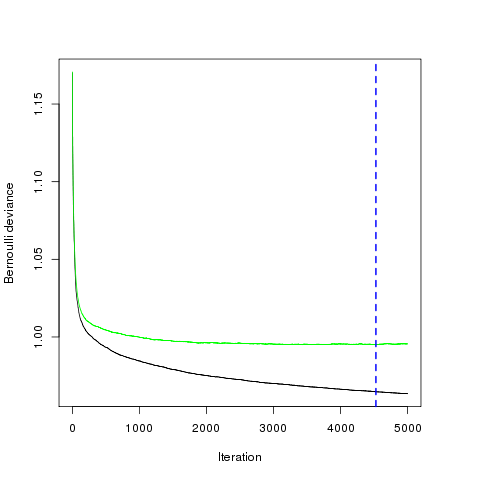

                                var   rel.inf
day                             day 47.520757
month                         month 23.690586
hour                           hour 14.309852
distance                   distance  6.286201
dayofweek                 dayofweek  5.344908
days_from_holiday days_from_holiday  2.847696

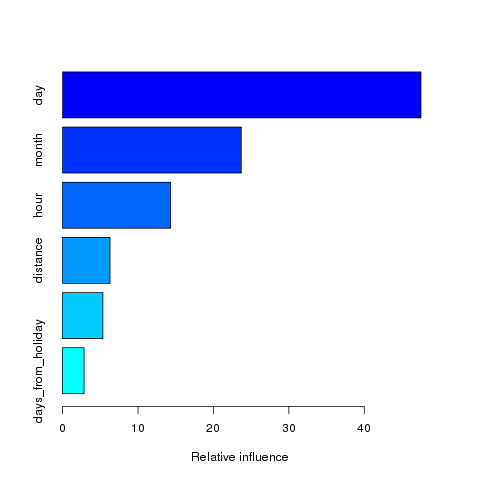

In [10]:
gbm.perf(gbm.model)
summary(gbm.model)

Using Gradient Boosted Machines we get reasonable results for our predictive model using a simple set of features. Can we do better? It's often the case that adding new features from additional data sources may improve the predictive performance of the model. We tackle this next.

## Pre-processing - iteration 2

A reasonable way to improve accuracy for this model is to layer-in weather data and with it add more informative features to our model. We can get this data from a publicly available dataset here: http://www.ncdc.noaa.gov/cdo-web/datasets/

We now add these additional weather-related features to our model: daily temperatures (min/max), wind speed, snow conditions and precipitation in the flight origin airport (ORD). 

So let's re-write our HIVE script to add these new features to our feature matrix. 

We make use of a HIVE UDF that resides in the tomap.jar, which allows us to implement functionality similar to PIVOT. We group by <station,year,month,day> and collect for each such group the various metrics in a map structure; then we translate this into individual columns for the metrics we want: TMIN, TMAX, SNOW, PRCP and AWND. tomap.jar is from code available here: https://github.com/wdavidw/hive-udf

In [11]:
hiveScriptStr = "

USE demo;
ADD FILE /home/jupyter/notebooks/airline/hiveudf.R;
ADD JAR /home/jupyter/notebooks/airline/tomap.jar;
CREATE TEMPORARY FUNCTION to_map as 'com.adaltas.UDAFToMap';

DROP TABLE fmat_2007_2;
CREATE TABLE fmat_2007_2 (delayed int, year int, month int, day int, dayofweek int, 
                          distance int, hour int, days_from_holiday int,
                          tmin float, tmax float, prcp float, awnd float, snow float) STORED AS ORC;

INSERT OVERWRITE TABLE fmat_2007_2
SELECT * FROM 
(SELECT delayed, f.year, f.month, f.day, dayofweek, distance, hour, days_from_holiday, tmin, tmax, prcp, awnd, snow
  FROM (
    FROM (
        SELECT year, month, day, dayofweek, depdelay, distance, crsdeptime 
        FROM flights
        WHERE flights.year=2007 and flights.origin='ORD' and flights.cancelled=0 and flights.depdelay is not NULL
        DISTRIBUTE BY month) t1
    REDUCE year, month, day, dayofweek, depdelay, distance, crsdeptime
    USING 'Rscript hiveudf.R' AS (delayed, year, month, day, dayofweek, distance, hour, days_from_holiday)
  ) f
  JOIN
  (
    SELECT station, year, month, day,
           mapvars['TMIN'] as tmin, mapvars['TMAX'] as tmax, 
           mapvars['SNOW'] as snow, mapvars['PRCP'] as prcp, mapvars['AWND'] as awnd
    FROM (SELECT station, year, month, day, to_map(metric,value) as mapvars
           FROM weather WHERE station = 'USW00094846'
           GROUP BY station, year, month, day) subq
  ) w     
  ON (w.year = f.year and w.month = f.month and w.day = f.day)
) subq;

DROP TABLE fmat_2008_2;
CREATE TABLE fmat_2008_2 (delayed int, year int, month int, day int, dayofweek int, 
                          distance int, hour int, days_from_holiday int,
                          tmin float, tmax float, prcp float, awnd float, snow float) STORED AS ORC;
INSERT OVERWRITE TABLE fmat_2008_2
SELECT * FROM 
(SELECT delayed, f.year, f.month, f.day, dayofweek, distance, hour, days_from_holiday, tmin, tmax, prcp, awnd, snow
  FROM (
    FROM (
        SELECT year, month, day, dayofweek, depdelay, distance, crsdeptime 
        FROM flights
        WHERE flights.year=2008 and flights.origin='ORD' and flights.cancelled=0 and flights.depdelay is not NULL
        DISTRIBUTE BY month) t1
    REDUCE year, month, day, dayofweek, depdelay, distance, crsdeptime
    USING 'Rscript hiveudf.R' AS (delayed, year, month, day, dayofweek, distance, hour, days_from_holiday)
  ) f
  JOIN
  (
    SELECT station, year, month, day,
           mapvars['TMIN'] as tmin, mapvars['TMAX'] as tmax, 
           mapvars['SNOW'] as snow, mapvars['PRCP'] as prcp, mapvars['AWND'] as awnd
    FROM (SELECT station, year, month, day, to_map(metric,value) as mapvars
           FROM weather WHERE station = 'USW00094846'
           GROUP BY station, year, month, day) subq
  ) w     
  ON (w.year = f.year and w.month = f.month and w.day = f.day)
) subq;
"

scriptFile = "/home/jupyter/notebooks/airline/iter2.hql"
fileConn<-file(scriptFile)
writeLines(hiveScriptStr, fileConn)
close(fileConn)

system2("hive", c("-f", scriptFile))
        

## Modeling - iteration 2

Now let's re-build the Gradient Boosted Tree models with the enahanced feature matrices.
As before, we first prepare our training set and test set:

In [12]:
# Load 2007 feature matrix and construct training set
train_data = exec.query("SELECT delayed, month, day, dayofweek, distance, hour, days_from_holiday, 
                         tmin, tmax, prcp, awnd, snow 
                         FROM fmat_2007_2")
train_data$month = as.factor(train_data$month)
train_data$day = as.factor(train_data$day)
train_data$dayofweek = as.factor(train_data$dayofweek)
train_data$delayed = as.integer(train_data$delayed)

# Load 2008 feature matrix and construct test set
test_data = exec.query("SELECT delayed, month, day, dayofweek, distance, hour, days_from_holiday, 
                        tmin, tmax, prcp, awnd, snow
                        FROM fmat_2008_2")
test_data$month = as.factor(test_data$month)
test_data$day = as.factor(test_data$day)
test_data$dayofweek = as.factor(test_data$dayofweek)
test_data$delayed = as.integer(test_data$delayed)

head(train_data, 5)

  delayed month day dayofweek distance hour days_from_holiday tmin tmax prcp
1       0     6  10         7     1721   17                 3  128  272    0
2       0     6  10         7      740    6                 3  128  272    0
3       0     6  10         7      740    9                 3  128  272    0
4       0     6  10         7      740   12                 3  128  272    0
5       0     6  10         7      740   15                 3  128  272    0
  awnd snow
1   25    0
2   25    0
3   25    0
4   25    0
5   25    0

Now let's try a gradient boosted tree model:

In [13]:
nTrees = 5000
require(gbm)
gbm.model <- gbm(delayed ~ ., data=train_data, n.trees=nTrees, verbose=F, shrinkage=0.5, 
                 distribution="bernoulli", interaction.depth=3, n.minobsinnode=30, cv.folds=3)
gbm.pr <- predict(gbm.model, newdata=test_data[,-1], n.trees=nTrees, type="response")
m.gbm = get_metrics(gbm.pr >= 0.5, as.logical(test_data$delayed))
print(sprintf("Gradient Boosted Machines: precision=%0.2f, recall=%0.2f, F1=%0.2f, accuracy=%0.2f", 
              m.gbm[1], m.gbm[2], m.gbm[3], m.gbm[4]))

[1] "Gradient Boosted Machines: precision=0.52, recall=0.38, F1=0.44, accuracy=0.73"


Using cv method...


[1] 3242

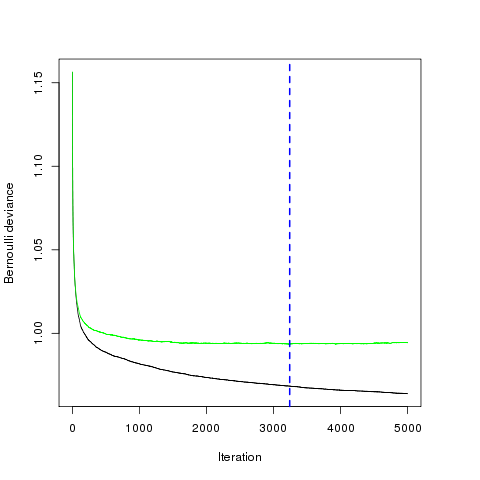

                                var   rel.inf
day                             day 41.169864
month                         month 16.258939
hour                           hour 13.566685
prcp                           prcp  7.032329
distance                   distance  6.156920
awnd                           awnd  3.836825
dayofweek                 dayofweek  3.272542
tmax                           tmax  2.861119
tmin                           tmin  2.156622
snow                           snow  2.027188
days_from_holiday days_from_holiday  1.660966

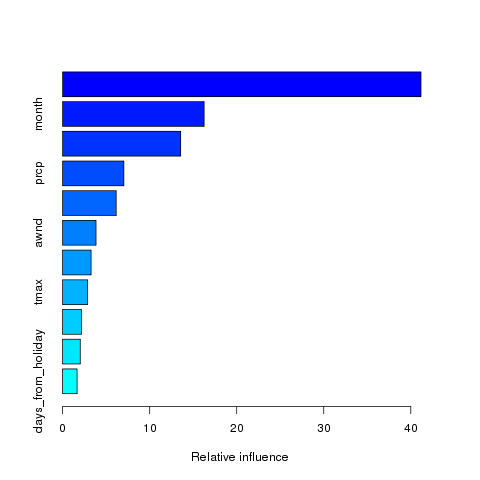

In [14]:
gbm.perf(gbm.model)
summary(gbm.model)

## Summary

In this demo we used an IPython notebook to demonstrate how to build a predictive model for airline delays. We have used HIVE and R on our HDP cluster to pre-process the data, build a feature matrix, and apply machine learning algorithms to the resulting datasets. We had shown how through iterations we add new features resulting in better model performance.